# Pneumonia Detection for Kaggle Dataset
Im folgenden werden Röntgenaufnahmen auf Lüngenentzündungen mit verschiedenen Modelen untersucht. Das Datenset wurde von [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) heruntergeladen: 
>The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

>Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

>For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

__Das Ergebnis ein Klassifikator mit 87%-Accuracy.__

#### Beispiel einer normalen Lunge:
![Normalelunge](Normal.jpeg)

#### Beispiel von Pneumonia:
Erkennbar an der unscharft verschlierten Grauton im rechten (=des Patienten linken Seite) Lungenflügel .
![Pneumonia-Lunge](Pneumonia.jpeg)

## Import Libraries

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.applications import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
from keras.models import Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras import models
from keras import layers
from keras import optimizers
from keras.applications import VGG16
from keras.applications.inception_v3 import InceptionV3
import random
from utils_plot import plot_both
from keras.callbacks import ModelCheckpoint


%matplotlib inline

## Define Constants

In [156]:
img_width, img_height = 1857,1317


data_dir = r"/Users/Andreas/Downloads/chest_xray/chest_xray"
train_dir = data_dir + r"/train"
valid_dir = data_dir + r"/val"
test_dir = data_dir + r"/test"
output_dir = data_dir

batch_size = 32
rescale = 1./255
target_size = (75,75)
class_mode = "binary"

num_test = 624
num_valid = 16


## Preprocessing

In [157]:
train_datagen = ImageDataGenerator(rescale = rescale,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=rescale)
test_datagen = ImageDataGenerator(rescale = rescale)


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = target_size,
                                                    batch_size = batch_size,
                                                    class_mode = class_mode,
                                                    shuffle=True)


validation_generator = validation_datagen.flow_from_directory(valid_dir,
                                                              target_size=target_size,
                                                              class_mode=class_mode,
                                                              batch_size=num_valid,
                                                              shuffle = False)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size = target_size,
                                                  batch_size = num_test,
                                                  class_mode = class_mode,
                                                  shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Data Visualization

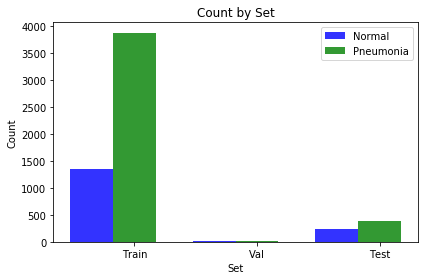

In [158]:
train_normal_num= np.count_nonzero(train_generator.classes==0)
train_pneumonia_num= np.count_nonzero(train_generator.classes==1)

val_normal_num= np.count_nonzero(validation_generator.classes==0)
val_pneumonia_num= np.count_nonzero(validation_generator.classes==1)

test_normal_num= np.count_nonzero(test_generator.classes==0)
test_pneumonia_num=  np.count_nonzero(test_generator.classes==1)

# data to plot
n_groups = 3
normal = (train_normal_num, val_normal_num, test_normal_num)
pneumonia = (train_pneumonia_num, val_pneumonia_num, test_pneumonia_num)

# create plot
fig, ax = plt.subplots()
index = np.arange(3)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, normal, bar_width,alpha=opacity,
color='b',
label='Normal')

rects2 = plt.bar(index + bar_width, pneumonia, bar_width,alpha=opacity,
color='g',
label='Pneumonia')

plt.xlabel('Set')
plt.ylabel('Count')
plt.title('Count by Set')
plt.xticks(index + bar_width, ('Train', 'Val', 'Test'))
plt.legend()

plt.tight_layout()
plt.show()


## Model mit VGG16

In [159]:
conv_base = VGG16(weights="imagenet",
                 include_top=False,
                 input_shape=(75,75,3))

In [160]:
conv_base.trainable = False

In [161]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0         
__________

In [162]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation ="relu", input_dim = 3*4*4*512, name ="Dense1"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid", name = "Dense2"))

In [163]:
model.compile(optimizer=optimizers.Adam(lr=0.005),
             loss="binary_crossentropy",
             metrics=["acc"])

In [164]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)              0         
_________________________________________________________________
Dense1 (Dense)               (None, 256)               524544    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
Dense2 (Dense)               (None, 1)                 257       
Total params: 15,239,489
Trainable params: 524,801
Non-trainable params: 14,714,688
_________________________________________________________________


In [165]:
filepath=r"/Users/Andreas/Pneumonia_Detection_Kaggle/Checkpoint_output/partialy_fitted.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [166]:
history = model.fit_generator(generator=train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=8,
                              validation_steps=8,
                              epochs=16)

Epoch 1/16
8/8 [==============================] - 46s 6s/step - loss: 1.2127 - acc: 0.6992 - val_loss: 0.4181 - val_acc: 0.9375
Epoch 2/16
8/8 [==============================] - 26s 3s/step - loss: 0.4512 - acc: 0.8242 - val_loss: 0.2964 - val_acc: 0.9375
Epoch 3/16
8/8 [==============================] - 27s 3s/step - loss: 0.4335 - acc: 0.7930 - val_loss: 0.3370 - val_acc: 0.8750
Epoch 4/16
8/8 [==============================] - 23s 3s/step - loss: 0.2863 - acc: 0.8789 - val_loss: 0.3070 - val_acc: 0.9375
Epoch 5/16
8/8 [==============================] - 24s 3s/step - loss: 0.2697 - acc: 0.8750 - val_loss: 0.2990 - val_acc: 0.8750
Epoch 6/16
8/8 [==============================] - 22s 3s/step - loss: 0.2643 - acc: 0.8984 - val_loss: 0.2803 - val_acc: 0.9375
Epoch 7/16
8/8 [==============================] - 24s 3s/step - loss: 0.2110 - acc: 0.9062 - val_loss: 0.2951 - val_acc: 0.9375
Epoch 8/16
8/8 [==============================] - 25s 3s/step - loss: 0.2448 - acc: 0.9023 - val_loss: 0

In [36]:
model.save("pneumoniaVGG.h5")

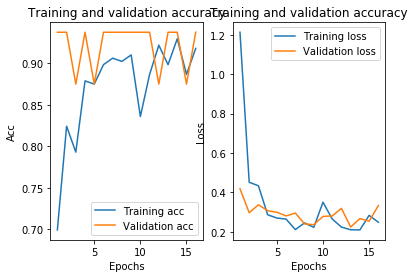

In [167]:
plot_both(history)

In [141]:
loss, acc = model.evaluate_generator(test_generator,steps=8)

In [142]:
acc

0.870192289352417

In [67]:
probabilites = model.predict_generator(test_generator,steps=1)

In [73]:
y_true = test_generator.classes
y_pred = probabilites > 0.5

data = confusion_matrix(y_true, y_pred)

df = pd.DataFrame(data)
df.index.name="Actual"
df.columns.name="Predicted"
df

Predicted,0,1
Actual,,
0,162,72
1,10,380


## Ergebnis:
__Der Klassifikator erreicht über 85% Treffergenauigkeit.__
Im Vergleich dazu erreichen Radiologen [nur bis zu 81%](https://www.ncbi.nlm.nih.gov/pubmed/887748). Andere veröffentlichte CNN für Pneumonia [erreichen 91%](https://becominghuman.ai/detecting-pneumonia-with-deep-learning-3cf49b640c14).